# Modèles Graphiques Parcimonieux pour la Modélisation Financière

## Encadrant
- Maxime Ferreira Da Costa

## Membres de projet
- Zakaria Bheddar
- Younes-Jihad Boumoussou
- Aymane Chaoui Adib
- Salma El Achkar
- Christophe Wang


Dans ce notebook, nous mettrons en pratique tous les résultats théoriques présentés dans ce rapport. Nous allons les implémenter et les appliquer progressivement à un exemple concret.

## Importation et installation des modules

In [1]:
!pip install -r requirements.txt

In [2]:
# Importations de bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg, optimize
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import covariance, cluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
import statsmodels.api as sm
from statsmodels import regression
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import timedelta


Nous allons commencer par étudier un exemple dont nous connaissons déjà la matrice de précision.

## Application  MVP pratique et illustration avec les outils disponibles

L'idée que nous souhaitons implémenter est de générer aléatoirement une matrice de précision. Cela nous permettra de créer des échantillons pour comparer les résultats des estimateurs avec cette matrice de précision de référence.

La première étape consiste à définir le nombre d'échantillons et le nombre de paramètres que nous avons.

In [3]:
n = 90
p = 20

Dans cette étape, nous allons initialiser un générateur de nombres aléatoires pour assurer la reproductibilité de nos résultats. Ensuite, nous utiliserons ce générateur pour créer une matrice de précision éparse (sparse) et définie positive. La matrice de précision sera générée avec un taux d'éparpillement contrôlé et des coefficients non nuls compris entre des valeurs spécifiques. Cette matrice de précision servira de référence pour générer des échantillons de données et comparer les performances des estimateurs par la suite.


In [4]:
prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(
    p, alpha=0.94, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)

Ce bloc de code effectue une série de transformations sur les matrices de covariance et de précision, ainsi que sur les données échantillons générées. Tout d'abord, il normalise la matrice de covariance en divisant chaque élément par la racine carrée de la variance de la variable correspondante. Cette normalisation garantit que les variables ont une variance unitaire, ce qui simplifie les calculs et rend les données comparables entre elles. Ensuite, il normalise la matrice de précision en ajustant ses éléments selon les écarts-types des variables. Cette étape est nécessaire pour que la matrice de précision soit cohérente avec la matrice de covariance normalisée, assurant ainsi des analyses statistiques correctes. Ces transformations sont essentielles pour garantir que les données générées sont correctement centrées et standardisées, ce qui est crucial pour des analyses statistiques robustes. Enfin, il génère des données échantillons à partir de la matrice de covariance normalisée et les centre autour de zéro en soustrayant la moyenne de chaque variable. Enfin, il normalise les données en les divisant par leur écart-type, assurant ainsi une variance unitaire pour chaque variable. Ces prétraitements sont essentiels pour garantir des analyses statistiques robustes et des performances optimales des estimateurs utilisés par la suite.


In [5]:
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)


Après avoir correctement normalisé les données pour les préparer à l'analyse, le bloc suivant sera utilisé pour estimer de trois manières différentes les matrices de covariance et de précision.

In [6]:
emp_cov = np.dot(X.T, X) / n

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

Après avoir calculé les matrices de covariance et de précision à partir des échantillons de données de trois manières différentes, nous passons à leur visualisation avec Matplotlib. La figure résultante est créée avec des sous-graphiques pour représenter les différentes estimations de covariances et de précisions. Tout d'abord, nous ajustons les marges de la figure avec `plt.subplots_adjust`. Ensuite, nous parcourons deux listes, `covs` et `precs`, qui contiennent les noms ainsi que les matrices de covariances et de précisions respectivement. Pour chaque élément de ces listes, nous créons un sous-graphique avec `plt.subplot` et affichons la matrice correspondante à l'aide de `plt.imshow`. Nous ajustons également les limites de couleur et les étiquettes des axes. Enfin, nous ajoutons des titres à chaque sous-graphique pour indiquer le type de matrice affichée. Si possible, nous définissons également la couleur de fond du sous-graphique. En résumé, ce code crée une visualisation des matrices de covariances et de précisions d'une manière fluide et esthétique, complétant ainsi l'étape précédente de calcul et de normalisation des données.

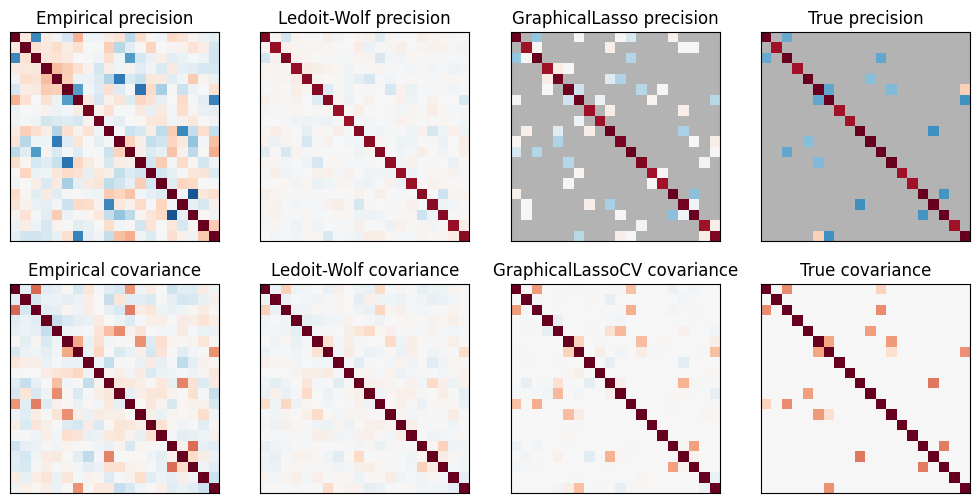

In [7]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# Plot the precisions first
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("Ledoit-Wolf", lw_prec_),
    ("GraphicalLasso", prec_),
    ("True", prec),
]
vmax_prec = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax_prec,
        vmax=vmax_prec,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")

# Plot the covariances after
covs = [
    ("Empirical", emp_cov),
    ("Ledoit-Wolf", lw_cov_),
    ("GraphicalLassoCV", cov_),
    ("True", cov),
]
vmax_cov = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax_cov, vmax=vmax_cov, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)

plt.show()


D'après les résultats de cette expérience, il semble que le modèle GraphicalLasso soit un bon estimateur pour les matrices de covariance et de précision. Cette conclusion est étayée par la comparaison visuelle des différentes estimations avec les véritables matrices. Le GraphicalLasso parvient à capturer les structures sous-jacentes des données avec précision, ce qui se traduit par des matrices estimées qui sont visuellement similaires aux matrices réelles. Cela suggère que le GraphicalLasso est robuste et efficace pour estimer les relations entre les variables dans un ensemble de données, même en présence de bruit et de données insuffisantes.

Une des qualités remarquables du module GraphicalLasso est son utilisation de l'approche de validation croisée, comme nous l'avons évoqué dans notre étude. Le paramètre alpha du GraphicalLasso, qui détermine la parcimonie du modèle, est défini par une validation croisée interne dans le GraphicalLassoCV. Comme le montre la figure 2, la grille pour calculer le score de validation croisée est itérativement affinée dans le voisinage du maximum. Cette méthode permet d'ajuster de manière adaptative le paramètre alpha pour obtenir le meilleur compromis entre parcimonie et précision du modèle. Une fois cette étape de validation croisée interne effectuée, nous pourrons examiner les résultats de l'analyse pour évaluer la performance et la généralisabilité du modèle GraphicalLasso.


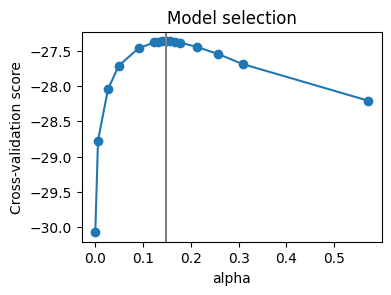

In [8]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

In [9]:
model.alpha_

0.14781290563434754

In [10]:
def calculate_rms(matrix1, matrix2):
    """
    Calcule la racine carrée de la moyenne des carrés (RMS) entre deux matrices.
    
    Args:
        matrix1 (np.array): La première matrice.
        matrix2 (np.array): La deuxième matrice.
        
    Returns:
        float: La valeur RMS entre les deux matrices.
    """
    # Vérifier que les matrices ont la même forme
    if matrix1.shape != matrix2.shape:
        raise ValueError("Les matrices doivent avoir la même forme")
    
    # Calculer la différence entre les matrices
    diff = matrix1 - matrix2
    
    # Calculer le carré de la différence
    squared_diff = np.square(diff)
    
    # Calculer la moyenne des carrés
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculer la racine carrée de la moyenne des carrés
    rms = np.sqrt(mean_squared_diff)
    
    return rms

In [11]:
# Calculer les RMS
rms_graphical_lasso = calculate_rms(cov_, cov)
rms_shrinkage_wolf = calculate_rms(lw_cov_, cov)
rms_empirical = calculate_rms(emp_cov, cov)

# Imprimer les résultats
print(f"RMS du Graphical Lasso: {rms_graphical_lasso}")
print(f"RMS du Shrinkage Wolf: {rms_shrinkage_wolf}")
print(f"RMS Empirique: {rms_empirical}")

RMS du Graphical Lasso: 0.03478118787732163
RMS du Shrinkage Wolf: 0.06597430301722651
RMS Empirique: 0.09572366329521087


## Implémentation concrète sur un portefeuille d'actifs

Dans cette section, nous allons nous concentrer sur un ensemble d'actifs réels pour mettre en pratique toutes les méthodes étudiées. Notre attention se portera principalement sur les variations quotidiennes des prix, car les cotations liées ont tendance à fluctuer les unes par rapport aux autres au cours d'une journée.

Dans notre travail, nous nous intéresserons au DAX allemand. Le DAX, ou Deutscher Aktienindex, est le principal indice boursier en Allemagne.

Il représente la performance des actions des 40 plus grandes entreprises cotées à la Bourse de Francfort (Francfort-sur-le-Main). Cet indice inclut les dividendes réinvestis.

Les cours des actions sont obtenus via le système de trading électronique Xetra. Selon Deutsche Börse, opérateur de Xetra, le DAX mesure la performance des sociétés allemandes les plus importantes en termes de volume de transactions et de capitalisation boursière.

Comparable aux indices FT 30, Dow Jones ou CAC 40, le DAX ne représente pas nécessairement l'ensemble de l'économie allemande en raison du nombre limité de titres qu'il contient.

Pour collecter les données nécessaires à notre analyse, nous allons utiliser le module yfinance. Ce module offre un accès convivial aux données financières, y compris les prix des actions, les volumes de transactions et d'autres informations pertinentes. En utilisant yfinance, nous pourrons extraire les données historiques et en temps réel des actifs financiers qui nous intéressent, ce qui sera essentiel pour notre analyse. Ce module facilite également l'extraction des variations quotidiennes des prix des actifs, ce qui nous permettra d'effectuer une analyse approfondie.

Pour importer automatiquement tous les tickers, c'est-à-dire leurs symboles boursiers, nous allons les extraire automatiquement à partir de Wikipédia en utilisant la méthode suivante :

In [12]:
stocks = "DAX"
web = pd.read_html("https://en.wikipedia.org/wiki/{}".format(stocks))[4]

Nous obtenons ainsi un DataFrame. Nous pouvons afficher les 5 premiers éléments avec la commande suivante :

In [13]:
web.head()

,Logo,Company,Prime Standard Sector,Ticker,Index weighting (%)1,Employees,Founded
0,NaN,Adidas,Apparel,ADS.DE,2.0,"061,401 (2021)",1924
1,NaN,Airbus,Aerospace & Defence,AIR.DE,6.0,"126,495 (2021)",1970
2,NaN,Allianz,Financial Services,ALV.DE,7.1,"155,411 (2021)",1890
3,NaN,BASF,Chemicals,BAS.DE,3.5,"111,047 (2021)",1865
4,NaN,Bayer,Pharmaceuticals,BAYN.DE,4.8,"099,637 (2021)",1863


Nous cherchons à récupérer la colonne des tickers. Nous procédons ainsi :

In [14]:
tickers = list(web.Ticker)

#Affichage des 5 premiers
tickers[:5]

['ADS.DE', 'AIR.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE']

In [15]:
#Définition du début et fin de la collecte de données
start = '2010-01-01'
end = '2018-01-01'

#Collecte
data = yf.download(
    tickers,
    start,
    end
)
data.head()

[*********************100%%**********************]  40 of 40 completed

4 Failed downloads:
['DTG.DE', 'ENR.DE', 'SHL.DE', 'P911.DE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262300400, endDate = 1514761200")


Price      Adj Close                                                         \
Ticker       1COV.DE     ADS.DE     AIR.DE     ALV.DE     BAS.DE    BAYN.DE   
Date                                                                          
2010-01-04       NaN  31.999929  11.662293  43.213932  22.495087  36.101334   
2010-01-05       NaN  33.009666  11.578990  43.345703  22.154026  35.442039   
2010-01-06       NaN  32.743729  11.658128  43.682491  22.294464  35.218002   
2010-01-07       NaN  33.030445  11.758090  43.179764  22.146502  34.757141   
2010-01-08       NaN  32.909946  11.949685  42.945488  22.078791  34.449890   

Price                                               ...  Volume           \
Ticker         BEI.DE     BMW.DE BNR.DE     CBK.DE  ...  RHM.DE   RWE.DE   
Date                                                ...                    
2010-01-04  40.290043  17.130247    NaN  43.821968  ...  175457  2022078   
2010-01-05  40.077507  17.269211    NaN  45.308559  ...  122509  2040667   
2010-01-06  40.047157  17.536453    NaN  46.824173  ...  186449  1535087   
2010-01-07  39.643784  17.691454    NaN  48.753117  ...  152821  1765257   
2010-01-08  38.498711  17.453606    NaN  49.384014  ...  192174  1665122   

Price                                                                       
Ticker       SAP.DE SHL.DE   SIE.DE SRT3.DE  SY1.DE VNA.DE  VOW3.DE ZAL.DE  
Date                                                                        
2010-01-04  3537806    NaN  3033854   26480  463375    NaN   906136    NaN  
2010-01-05  2907653    NaN  2867257    8820  431828    NaN   893352    NaN  
2010-01-06  3772263    NaN  2403228   10936  551105    NaN  1202268    NaN  
2010-01-07  6331741    NaN  3701624   10448  393298    NaN  1108024    NaN  
2010-01-08  5061607    NaN  2922356    5320  642582    NaN   937837    NaN  

[5 rows x 240 columns]

Parfois, plusieurs actifs ne sont pas présents dans la dataframe, alors nous cherchons à les identifier pour les éliminer de notre analyse.

In [16]:
failed_tickers = data.columns.get_level_values(1)[data.isnull().any()].unique().tolist()
tickers = [ticker for ticker in tickers if ticker not in failed_tickers]

Et maintenant, on va éliminer tous ces failed tickers de la data

In [17]:
data.drop(columns=failed_tickers, level=1, inplace=True)
data.head()

Price       Adj Close                                                         \
Ticker         ADS.DE     AIR.DE     ALV.DE     BAS.DE    BAYN.DE     BEI.DE   
Date                                                                           
2010-01-04  31.999929  11.662293  43.213932  22.495087  36.101334  40.290043   
2010-01-05  33.009666  11.578990  43.345703  22.154026  35.442039  40.077507   
2010-01-06  32.743729  11.658128  43.682491  22.294464  35.218002  40.047157   
2010-01-07  33.030445  11.758090  43.179764  22.146502  34.757141  39.643784   
2010-01-08  32.909946  11.949685  42.945488  22.078791  34.449890  38.498711   

Price                                                   ...  Volume           \
Ticker         BMW.DE     CBK.DE     CON.DE     DB1.DE  ... MUV2.DE  PAH3.DE   
Date                                                    ...                    
2010-01-04  17.130247  43.821968  23.963982  38.767899  ...  873193   357930   
2010-01-05  17.269211  45.308559  25.463106  38.688568  ...  797939   595248   
2010-01-06  17.536453  46.824173  25.629677  38.212563  ...  727120   828955   
2010-01-07  17.691454  48.753117  28.913919  37.538223  ...  948916  1544222   
2010-01-08  17.453606  49.384014  29.448200  36.923382  ...  902151  1007529   

Price                                                                           
Ticker      QIA.DE  RHM.DE   RWE.DE   SAP.DE   SIE.DE SRT3.DE  SY1.DE  VOW3.DE  
Date                                                                            
2010-01-04  538058  175457  2022078  3537806  3033854   26480  463375   906136  
2010-01-05  329447  122509  2040667  2907653  2867257    8820  431828   893352  
2010-01-06  440462  186449  1535087  3772263  2403228   10936  551105  1202268  
2010-01-07  487730  152821  1765257  6331741  3701624   10448  393298  1108024  
2010-01-08  620875  192174  1665122  5061607  2922356    5320  642582   937837  

[5 rows x 186 columns]

Nous allons inspecter les colonnes du DataFrame afin d'extraire les données nécessaires.

In [18]:
data.columns

MultiIndex([('Adj Close',  'ADS.DE'),
            ('Adj Close',  'AIR.DE'),
            ('Adj Close',  'ALV.DE'),
            ('Adj Close',  'BAS.DE'),
            ('Adj Close', 'BAYN.DE'),
            ('Adj Close',  'BEI.DE'),
            ('Adj Close',  'BMW.DE'),
            ('Adj Close',  'CBK.DE'),
            ('Adj Close',  'CON.DE'),
            ('Adj Close',  'DB1.DE'),
            ...
            (   'Volume', 'MUV2.DE'),
            (   'Volume', 'PAH3.DE'),
            (   'Volume',  'QIA.DE'),
            (   'Volume',  'RHM.DE'),
            (   'Volume',  'RWE.DE'),
            (   'Volume',  'SAP.DE'),
            (   'Volume',  'SIE.DE'),
            (   'Volume', 'SRT3.DE'),
            (   'Volume',  'SY1.DE'),
            (   'Volume', 'VOW3.DE')],
           names=['Price', 'Ticker'], length=186)

In [19]:
s= set()
for column,_ in list(data.columns):
    s.add(column)
s

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

Ce qui nous intéresse principalement, c'est la variation quotidienne entre le prix de clôture et le prix d'ouverture. Cette mesure est cruciale car les cotations liées ont tendance à fluctuer en relation les unes avec les autres au cours d'une journée de trading. En analysant cette variation, nous pouvons étudier les mouvements de prix historiques, calculer des indicateurs techniques, et former des modèles prédictifs pour anticiper les évolutions futures des prix.

In [20]:
closing_prices = data["Close"]
opening_prices = data["Open"]

variation = closing_prices-opening_prices
variation.head()

Ticker,ADS.DE,AIR.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,CBK.DE,CON.DE,DB1.DE,...,MUV2.DE,PAH3.DE,QIA.DE,RHM.DE,RWE.DE,SAP.DE,SIE.DE,SRT3.DE,SY1.DE,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.545002,0.105000,0.739998,1.389999,0.186977,0.595001,0.230000,0.665138,0.799892,0.290001,...,-1.000000,0.312004,0.160587,0.505001,0.508308,0.059998,0.628952,0.43750,0.365001,-0.646118
2010-01-05,0.720001,0.059999,0.309998,-0.595001,-0.797119,-0.224998,0.350002,1.907265,2.179161,0.170002,...,0.349998,1.384781,-0.235527,-0.610001,-0.478401,-0.134998,0.096092,0.03625,0.030001,-1.242523
2010-01-06,-0.399998,0.020000,0.349998,0.230000,-0.246025,-0.084999,0.360001,1.562675,0.229156,-0.619999,...,-0.949997,-0.085480,0.203409,-1.070000,-0.039864,0.489998,0.262062,0.03250,0.175000,1.401566
2010-01-07,0.379997,0.150000,-0.449997,-0.014999,-0.442844,-0.485001,0.449997,2.107609,2.940140,-0.720001,...,0.650002,2.235310,0.069588,0.494999,-0.049835,1.014999,0.725037,-0.11500,-0.125000,0.775337
2010-01-08,-0.125000,-0.025000,-1.190002,-0.230000,-0.482204,-1.369999,-0.680000,-1.121922,0.691795,-0.960003,...,-0.750000,-0.666748,-0.171293,0.090000,-0.358810,0.025002,0.087353,0.01500,0.059999,0.556648


Maintenant que toutes les données sont préparées, il ne reste plus qu'à normaliser et ajuster notre modèle GraphicalLasso. Comme mentionné précédemment, ce module intègre une validation croisée interne qui simplifie notre étude en utilisant une approche uniforme.

In [21]:
alphas = np.logspace(-1.5, 1, num=10)
model = covariance.GraphicalLassoCV(alphas=alphas)

X = variation.copy()
X /= X.std(axis=0)
model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

Ce qui est remarquable dans ce module, c'est sa capacité à effectuer automatiquement la validation croisée. Voici le graphe correspondant.

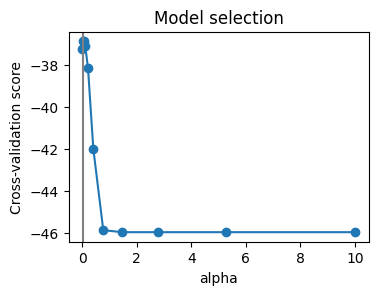

In [22]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

La valeur correspondante de lambda pour ce module est...

In [23]:
model.alpha_

0.03162277660168379

Maintenant que tout se déroule sans problème, nous allons tenter d'utiliser les résultats pour la visualisation. Une des premières étapes consistera à effectuer un clustering, suivi d'une visualisation du graphe. Pour la méthode de clustering, nous utiliserons AffinityPropagation.

AffinityPropagation est un algorithme de clustering qui identifie automatiquement un ensemble de points de données exemplaires, également appelés "exemplars". Il utilise la similarité entre les points de données pour regrouper les données en clusters. L'algorithme est basé sur la propagation de l'affinité entre les points de données, où chaque point communique avec tous les autres points pour décider des points exemplaires. Cette approche permet à AffinityPropagation de détecter les clusters de forme arbitraire et de taille variable dans les données.

In [24]:
_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
n_labels

6

Après avoir effectué le clustering, nous obtiendrons une liste de labels qui correspond à celle des tickers, mais chaque position indiquera le cluster auquel le ticker est attribué.

In [25]:
labels

array([0, 3, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 5, 4, 1, 2, 1, 3, 3, 4, 3, 1,
       3, 4, 3, 5, 1, 1, 6, 2, 3], dtype=int64)

Ainsi, nous mettons en œuvre le code suivant pour identifier les actifs qui présentent des similarités entre eux.

In [26]:
clusters = {}

for i in range(len(labels)):
    cluster = labels[i]+1
    if cluster not in clusters:
        clusters[cluster]=[]
    clusters[cluster].append(tickers[i])

for cluster in clusters:
    print("Cluster "+str(cluster)+" : "+",".join(clusters[cluster]))

Cluster 1 : ADS.DE
Cluster 4 : AIR.DE,BMW.DE,CON.DE,IFX.DE,MBG.DE,MTX.DE,PAH3.DE,RHM.DE,VOW3.DE
Cluster 2 : ALV.DE,BAS.DE,BAYN.DE,CBK.DE,DBK.DE,DB1.DE,DTE.DE,HNR1.DE,HEN3.DE,MUV2.DE,SAP.DE,SRT3.DE
Cluster 3 : BEI.DE,HEI.DE,SY1.DE
Cluster 6 : EOAN.DE,RWE.DE
Cluster 5 : FRE.DE,MRK.DE,QIA.DE
Cluster 7 : SIE.DE


À des fins de visualisation, nous devons disposer les différents symboles sur un canevas 2D. Pour ce faire, nous utilisons des techniques d'apprentissage de la variété pour obtenir un plongement en 2D. Nous optons pour un solveur eigen dense pour assurer la reproductibilité, car arpack est initié avec des vecteurs aléatoires que nous ne contrôlons pas. De plus, nous utilisons un grand nombre de voisins pour capturer la structure à grande échelle de manière précise.

In [27]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

Les sorties des 3 modèles sont combinées dans un graphique 2D où les nœuds représentent les actions et les arêtes :

- les étiquettes de cluster sont utilisées pour définir la couleur des nœuds
- le modèle de covariance parcimonieuse est utilisé pour afficher la force des arêtes
- l'incorporation en 2D est utilisée pour positionner les nœuds dans le plan

Cet exemple comporte une quantité significative de code lié à la visualisation, car la visualisation est cruciale ici pour afficher le graphe. L'un des défis est de positionner les étiquettes en minimisant les chevauchements. Pour cela, nous utilisons une heuristique basée sur la direction du voisin le plus proche le long de chaque axe.


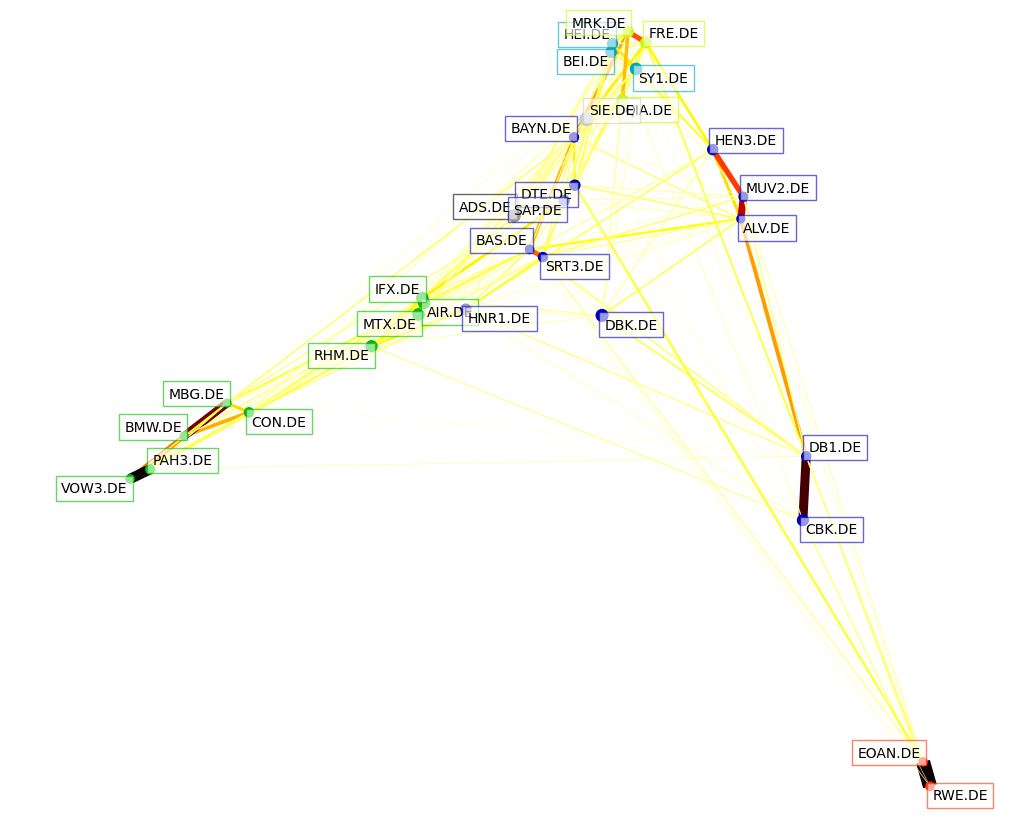

In [28]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")


partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

start_idx, end_idx = np.where(non_zero)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()

## Stationnarité d'un actif financier

Dans cette section, nous examinerons la stationnarité des actifs financiers, car l'une des hypothèses de Graphical Lasso est que les actifs sont stationnaires.

Nous commencerons par examiner un exemple basé sur une base de données que nous possédons.

In [29]:
register_matplotlib_converters()

#Base de Données de l'exemple#

df = pd.read_csv(
    "./data/asset_price.csv",
    parse_dates=["Month"],
    index_col=["Month"],
)

In [30]:
df.head()

,Value of the asset
Month,
2000-01-01,112
2000-02-01,118
2000-03-01,132
2000-04-01,129
2000-05-01,121


Il y a deux tests principaux pour déterminer si une série temporelle donnée est stationnaire :

— *Statistiques roulantes* : Tracer la moyenne mobile et l’écart-type mobile. Une série temporelle est
considérée comme stationnaire si elle demeure constante au fil du temps.

— *Test de Dickey-Fuller augmenté (ADF)* : On considère qu’une série temporelle est stationnaire si
la p-valeur est faible et si les valeurs critiques aux niveaux de confiance de 1 %, 5 %, et 10 % sont très proches des statistiques du test ADF (Augmented Dickey-Fuller).

Appliquons ces deux tests à notre série :

**1er Test :**

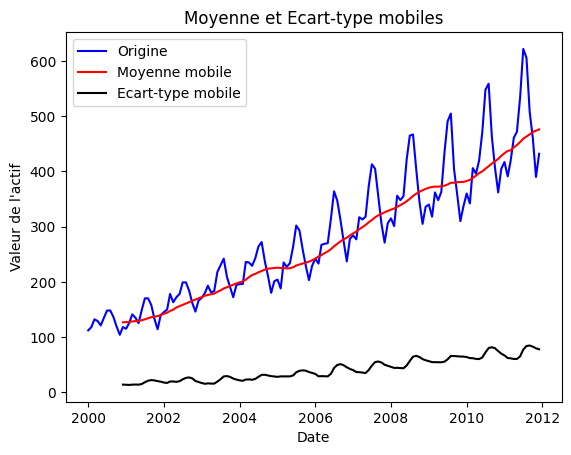

In [31]:
plt.xlabel("Date")
plt.ylabel("Valeur de l'actif")

#Traçage de la moyenne mobile et l'écart-type mobile#

rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.plot(df, color="blue", label="Origine")
plt.plot(rolling_mean, color="red", label="Moyenne mobile")
plt.plot(rolling_std, color="black", label="Ecart-type mobile")
plt.legend(loc="best")
plt.title("Moyenne et Ecart-type mobiles")
plt.show()

Comme nous pouvons le voir, la moyenne mobile et l’écart-type mobile varient avec le temps. Nous
pouvons donc conclure que la série n’est pas stationnaire.

**2ème Test :**

In [32]:
result = adfuller(df["Value of the asset"])

In [33]:
#Calcul des statistiques ADF, p-valeur et valeurs critiques#

print("Statistiques ADF : {}".format(result[0]))
print("p-value : {}".format(result[1]))
print("Valeurs Critiques :")
for key, value in result[4].items():
    print("\t{}: {}".format(key, value))

Statistiques ADF : 0.8153688792060463
p-value : 0.991880243437641
Valeurs Critiques :
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


La statistique ADF est loin des valeurs critiques et la p-value est supérieure au seuil (0,05). On peut
donc conclure que la série temporelle n’est pas stationnaire

Nous créons ainsi une fonction permettant d’exécuter les deux tests qui déterminent si une série temporelle donnée est stationnaire 

In [34]:
def get_stationarity(timeseries):

    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    original = plt.plot(timeseries, color="blue", label="Origine")
    mean = plt.plot(rolling_mean, color="red", label="Moyenne Mobile")
    std = plt.plot(rolling_std, color="black", label="Ecart-type Mobile")
    plt.legend(loc="best")
    plt.title("Moyenne et écart-type Mobiles")
    plt.show(block=False)

    result = adfuller(timeseries["Value of the asset"])
    print("Statistiques ADF : {}".format(result[0]))
    print("p-value : {}".format(result[1]))
    print("Valeurs Critiques :")
    for key, value in result[4].items():
        print("\t{}: {}".format(key, value))

Pour rendre la moyenne et écart-type mobiles moins variables dans le temps (pour avoir la stationnarité), nous composons la fonction log les valeurs de la série.

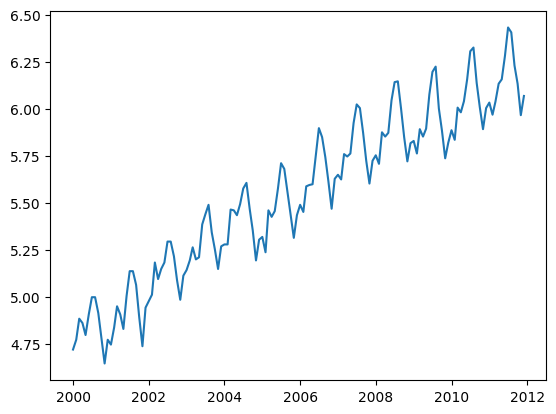

In [35]:
df_log = np.log(df)
plt.plot(df_log)
plt.show()

**Stationnarisation d’une série :**

Il existe de multiples transformations que nous pouvons appliquer à une série temporelle pour la rendre
stationnaire.

Par exemple nous pouvons soustraire la moyenne mobile de la série

**Test 1 :**

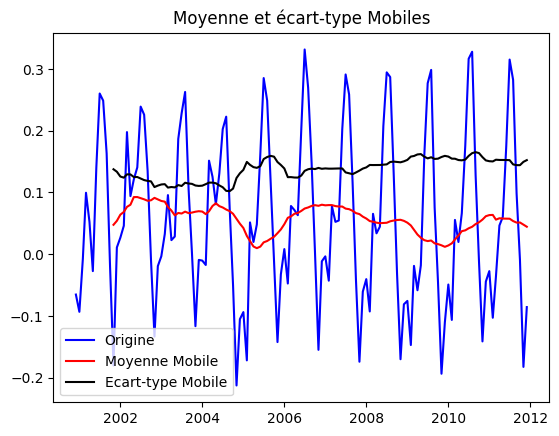

Statistiques ADF : -3.1629079913008753
p-value : 0.022234630001242737
Valeurs Critiques :
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [36]:
#Application de la fonction get_stationarity pour les nouvelles valeurs de la série après soustraction 
#de la moyenne mobile

rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

## Optimisation du portefeuille

On souhaite appliquer les résultats obtenues, et donc on va essayer de proposer une simulation, où l'on va choisir les actifs sur lesquels on veut investir (l'univers d'investissement), le montant de départ sur lequel on veut investir et la periode de simulation et qui va  nous donner l'evolution de notre portfolio si l'on suit la TMP. 

In [37]:

# Liste des dates où on va recalculer les poids 
# Chaque 6 mois de janvier 2010 à juin 2020
dates = ['2010-01-01','2010-06-01','2011-01-01','2011-06-01','2012-01-01','2012-06-01','2013-01-01','2013-06-01','2014-01-01','2014-06-01','2015-01-01','2015-06-01','2016-01-01','2016-06-01','2017-01-01','2017-06-01','2018-01-01','2018-06-01','2019-01-01','2019-06-01','2020-01-01','2020-06-01']

In [38]:

# Fonction qui prends les dates où on recalcule les poids et les noms des actifs sur lesquels on veut investir
# et qui retourne une liste de poids des investissements à faire à chaque date de 'dates'
def investing(dates,shares):
    #Initialiser
    weight_list=[]
    n=len(dates)-2
    for i in range(n): # pour chaque date i
        # Initialiser la liste des données historiques
        df_list = []
        for e in shares :
            df_list.append(yf.download(e, dates[i], dates[i+2])['Adj Close']) # Ajouter les dates sur an
        df = pd.concat(df_list, join = 'outer', axis = 1)
        df.columns = shares
        mu = expected_returns.mean_historical_return(df) # Calcule de la moyenne historique sur une année
        S = risk_models.sample_cov(df)  # Calcule de la matrice de covariance
        ef = EfficientFrontier(mu, S) # Calcule de la frontière efficace
        weights = ef.max_sharpe()  # calculer les poids qui maximisent le rapport de Sharpe
        clean_weights = ef.clean_weights() # arrondir les poids 
        weight_list.append(clean_weights)
    return weight_list


# Fonction qui retourne une liste des rapports de la valorisation d'un actif entre deux dates consecutives 
# et qui prends comme argument la liste des dates et les valorisations contenant les dates souhaitaient
def rapports(assets,dates):
    dates = pd.to_datetime(dates, format="%Y-%m-%d")
    ratios = []
    n = len(dates) -1
    six_months = timedelta(days=182)
    current_date = assets.index[0]
    for i in range(n):
        next_date = assets.index.asof(current_date + six_months)
        ratio = assets.loc[next_date] / assets.loc[current_date]
        ratios.append(ratio)
        current_date = next_date
    return ratios

# Fonctiom qui prends la liste de poids sur les dates générées par investing, les dates, le montant d'investissement 
# de départ, et les actifs sur lesquels on veut investir et qui retourne l'évolution du portefeuille sous forme de liste
def portfolio_evolution( weight_list , dates , montant_depart , shares):
    portefeuille_evolution = [montant_depart]
    n = len(dates) - 2
    rapport = { actif : rapports(yf.download(actif, dates[0], dates[-1])['Adj Close'],dates) for actif in shares} #dict des rapports obtenus par rapport
    for periode in range(n):
        weights = weight_list[periode]
        montant_actuel = portefeuille_evolution[-1]
        montant_suivant = sum( [ weights[actif]*montant_actuel*rapport[actif][periode] for actif in shares] ) 
        portefeuille_evolution.append(montant_suivant)
    return portefeuille_evolution

In [39]:
weight_list = investing(dates,['aapl', 'msft', 'goog','nvda','amzn'])
a= portfolio_evolution(weight_list,dates,10000,['aapl', 'msft', 'goog','nvda','amzn'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

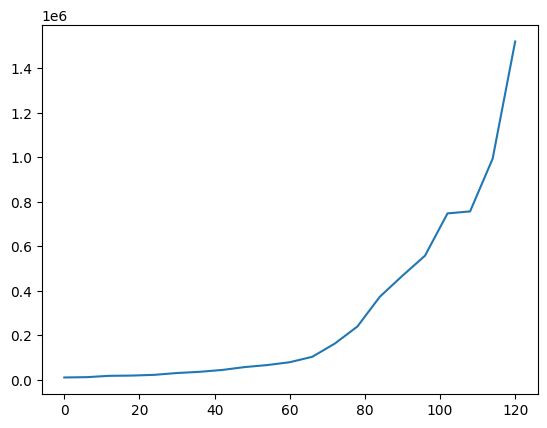

In [40]:
plt.plot([6*i for i in range(len(a))],a)
plt.show()